<a href="https://colab.research.google.com/github/The-Gupta/TED-Talks-Analysis/blob/main/EDA_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 14-DEC-20  0245.

In [27]:
import requests, bs4, sys, os, time, json, re, random, ast, itertools
from multiprocessing import Process, Manager
import pandas as pd
import numpy as np
import urllib.request
from bs4 import BeautifulSoup
from datetime import datetime
from nltk.corpus import words
import spacy, nltk, re, unicodedata, string
from textblob import TextBlob
from collections import Counter


nltk.download('all')

ENGLISH_WORDS = set(words.words())



'''  IGNORING WARNINGS  '''
import warnings
warnings.filterwarnings('ignore')


'''  NOTEBOOK DISPLAY SETTINGS  '''
pd.options.display.max_rows = 100    # None
pd.options.display.max_columns = 300  # 

pd.set_option('display.max_colwidth', 300)  # -1
pd.set_option('display.expand_frame_repr', False)


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

In [28]:
# Using Google Drive for storage.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
cd "/content/gdrive/My Drive/Vishal/PersonalProject/TED/7_EDA_1/"

/content/gdrive/My Drive/Vishal/PersonalProject/TED/7_EDA_1


In [30]:
# Starting to explore with transcript at the core.
df  =  pd.read_csv('TED_Talk.csv')
ORIGINAL_COLUMNS  =  df.columns.tolist()

print(df.shape)
df  =  df[~df['transcript'].isna()]    # Remove talks w/o transcripts.
print(df.shape)
df  =  df[df['language']=='en']    # Removing 3 talks that are not in English.
print(df.shape)

(4883, 52)
(4315, 52)
(4312, 52)


In [31]:
df.sample(1)

,talk__id,talk__name,talk__description,view_count,comment_count,duration,transcript,video_type_name,event,number_of__speakers,speaker__id,speaker__name,speaker__description,speaker__who_he_is,speaker__why_listen,speaker__what_others_say,speaker__is_published,all_speakers_details,is_talk_featured,has_talk_citation,recording_date,published_timestamp,talks__tags,number_of__tags,language,native_language,language_swap,is_subtitle_required,url__webpage,url__audio,url__video,url__photo__talk,url__photo__speaker,url__subtitled_videos,number_of__subtitled_videos,talk__download_languages,number_of__talk__download_languages,talk__more_resources,number_of__talk__more_resources,talk__recommendations__blurb,talk__recommendations,number_of__talk__recommendations,related_talks,number_of__related_talks,intro_duration,ad_duration,post_ad_duration,external__duration,external__start_time,talks__player_talks__resources__h264__00__bitrate,talks__take_action,number_of__talks__take_actions
2992,1260,A plane you can drive,"A flying car -- it's an iconic image of the future. But after 100 years of flight and automotive engineering, no one has really cracked the problem. Pilot Anna Mracek Dietrich and her team flipped the question, asking: Why not build a plane that you can drive?",1012447,NaN,578,"What is it about flying cars? We've wanted to do this for about a hundred years. And there are historic attempts that have had some level of technical success. But we haven't yet gotten to the point where on your way here this morning you see something that really, truly seamlessly integrates th...",TED Stage Talk,TEDGlobal 2011,1,1034.0,Anna Mracek Dietrich,Inventor,"Anna Mracek Dietrich is one of the creators of the Transition, the ""plane you can drive.""","Anna Mracek Dietrich is a private pilot trying to making aviation accessible, safe -- and a reasonable way to get to work. With husband Carl and their team at Terrafugia, in Massachusetts, they are building a driveable aircraft (or, as they also term it, the Roadable Aircraft), which is designed...","The first flight was remarkably unremarkable. I've flown several thousand hours in everything from Piper Cubs to F-16s, and the Transition flew like a really nice airplane.",True,"[{'id': '1034', 'slug': 'anna_mracek_dietrichs', 'is_published': True, 'firstname': 'Anna Mracek', 'lastname': 'Dietrich', 'middleinitial': '', 'title': '', 'description': 'Inventor', 'photo_url': 'https://pe.tedcdn.com/images/ted/b7f192c4110ec3e48cafae91aec9f41161afc131_254x191.jpg', 'whatother...",True,NaN,2011-07-15,2011-11-02 15:22:05,"['cars', 'design', 'flight', 'invention', 'transportation']",5,en,en,False,False,https://www.ted.com/talks/anna_mracek_dietrich_a_plane_you_can_drive,https://download.ted.com/talks/AnnaMracekDietrich_2011G.mp3?apikey=acme-roadrunner,"{'low': 'https://download.ted.com/talks/AnnaMracekDietrich_2011G-light.mp4?apikey=acme-roadrunner', 'medium': 'https://download.ted.com/talks/AnnaMracekDietrich_2011G.mp4?apikey=acme-roadrunner', 'high': 'https://download.ted.com/talks/AnnaMracekDietrich_2011G-480p.mp4?apikey=acme-roadrunner'}",https://s3.amazonaws.com/talkstar-photos/uploads/1f7546a1-12f0-4822-97e9-087516324333/AnnaMracekDietrich_2011G-embed.jpg,https://pe.tedcdn.com/images/ted/b7f192c4110ec3e48cafae91aec9f41161afc131_254x191.jpg,"{'ja': {'name': 'Japanese', 'high': 'https://download.ted.com/talks/AnnaMracekDietrich_2011G-480p-ja.mp4?apikey=acme-roadrunner', 'low': 'https://download.ted.com/talks/AnnaMracekDietrich_2011G-low-ja.mp4?apikey=acme-roadrunner'}, 'zh-tw': {'name': 'Chinese, Traditional', 'high': 'https://downlo...",31,"[{'languageName': 'Greek', 'endonym': 'Ελληνικά', 'languageCode': 'el', 'ianaCode': 'el', 'isRtl': False}, {'languageName': 'English', 'endonym': 'English', 'languageCode': 'en', 'ianaCode': 'en', 'isRtl': False}, {'languageName': 'Vietnamese', 'endonym': 'Tiếng Việt', 'languageCode': 'vi', 'ian...",31,NaN,0,NaN,NaN,0,"[{'id': '5', 'hero': 'https://s3.amazonaws.com/talksta

# Functions, Global Variables

In [33]:
# Stopwords and Bad words.
STOP_WORDS = nltk.corpus.stopwords.words('english')

with open('most_common_english_words_1000.txt') as f:    
    COMMON_WORDS__TOP_1000_1 = [line.rstrip() for line in f]    # https://gist.github.com/deekayen/4148741
with open('most_common_english_words_1000__ef_com.txt') as f:    
    COMMON_WORDS__TOP_1000_2 = [line.rstrip() for line in f]    # https://www.ef.com/wwen/english-resources/english-vocabulary/top-1000-words/
with open('most_common_english_words_3000__ef_com.txt') as f:    
    COMMON_WORDS__TOP_3000   = [line.rstrip() for line in f]    # https://www.ef.com/wwen/english-resources/english-vocabulary/top-3000-words/

with open('bad_words.txt') as f:    
    BAD_WORDS = [line.rstrip() for line in f]    # https://www.kaggle.com/shaz13/feature-engineering-for-nlp-classification

PUNCTUATION = string.punctuation    # !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~



# Source:  https://github.com/dipanjanS/text-analytics-with-python/blob/master/Old-First-Edition/Ch04_Text_Classification/normalization.py#L22
from contractions import CONTRACTION_MAP
def expand_contractions(text):    # Expand Short Forms. Ex: I'm -> I am.
    if text:
        global CONTRACTION_MAP
        
        text  =  re.sub(' +',   ' ',   text.replace('(', ' (').replace(')', ') ').replace('!', '! ').replace('?', '? '))    # Fixing spacing issues in the Transcript.

        contraction_mapping=CONTRACTION_MAP

        contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                        flags=re.IGNORECASE|re.DOTALL)
        def expand_match(contraction):
            match = contraction.group(0)
            first_char = match[0]
            expanded_contraction = contraction_mapping.get(match)\
                                    if contraction_mapping.get(match)\
                                    else contraction_mapping.get(match.lower())                       
            expanded_contraction = first_char+expanded_contraction[1:]
            return expanded_contraction
            
        expanded_text = contractions_pattern.sub(expand_match, text)
        expanded_text = re.sub("'", "", expanded_text)
        return expanded_text
    else:    return ''



# Lemmatization
nlp = spacy.load('en', parse=True, tag=True, entity=True)
def lemmatize_text(text):
    if text:
        text = nlp(text)
        return ' '.join([word.lemma_   if word.lemma_ != '-PRON-' else word.text   for word in text])
    else:    return ''




def remove_accented_chars(text):    
    # Convert Non-ASCII Characters to equivalent ASCII Characters.
    # Ex:  'Sómě Áccěntěd těxt' -> 'Some Accented text'
    # Source:  https://github.com/dipanjanS/nlp_essentials/blob/master/notebooks/01_Text_Wrangling_Examples.ipynb
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


# Spelling Correction
# Source:  https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing
try:
    from spellchecker import SpellChecker
except:
    !pip install pyspellchecker
    from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)


# Text Normalization
def normalize_text(text):
    if text:
        # text = remove_accented_chars(text)
        # text = correct_spellings(text)
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = text.lower().strip()

        tokens = nltk.word_tokenize(text)
        filtered_tokens  =  [token   for token in tokens   if token not in STOP_WORDS]
        # filtered_tokens  =  [token   for token in tokens   if token not in CUSTOM_STOP_WORDS]
        # filtered_tokens  =  [token   for token in tokens   if token not in BAD_WORDS]
        text = ' '.join(filtered_tokens)

        return text
    else:    return ''


def normalize_text2(text):
    # Keeping only mainstream english words excluding 1000 most common words.
    if text:
        tokens = nltk.word_tokenize(text)
        filtered_tokens  =  [token   for token in tokens   if ((token in ENGLISH_WORDS) and (token not in COMMON_WORDS__TOP_1000_2))]
        text = ' '.join(filtered_tokens)
        return text
    else:    return ''



# Sentiment with TextBlob.
def get_polarity(text):
    # Polarity:  Range: [-1, 1]  --  negative to positive
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    # Subjectivity:  Range: [0, 1]  --  objective to subjective
    return TextBlob(text).sentiment.subjectivity






# POS Tag Count.
pos_dic  =  {    'noun' : ['NN', 'NNS', 'NNP', 'NNPS'],
                 'pron' : ['PRP', 'PRP$', 'WP', 'WP$'],
                 'verb' : ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
                 'adj' :  ['JJ', 'JJR', 'JJS'],
                 'adv' : ['RB', 'RBR', 'RBS', 'WRB']
            }

# function to check and get the part of speech tag count of a words in a given sentence
def pos_check(x, flag):
    cnt = 0
    
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    
    return cnt

# Creating some more columns with Text using basic NLP

In [34]:
%%time

columns  =  ['talk__name', 'talk__description',  'speaker__who_he_is', 'speaker__why_listen', 'speaker__what_others_say']

for  col  in columns:
    print(col)
    df[col + '__2']   =   df[col].fillna('').apply(expand_contractions)
    df[col + '__3']   =   df[col + '__2'].fillna('').apply(lemmatize_text)
    df[col + '__4']   =   df[col + '__3'].fillna('').apply(normalize_text)


    df[col + '__sentiment']       =   df[col + '__2'].fillna('').apply(get_polarity)
    df[col + '__subjectivity']   =   df[col + '__2'].fillna('').apply(get_subjectivity)


    df[col + '__char_count']     =   df[col].fillna('').apply(len)
    df[col + '__word_count']     =   df[col].fillna('').apply(lambda x:  len(x.split()))
    df[col + '__word_density']   =   df[col + '__char_count'] / (df[col + '__word_count']+1)

    df[col + '__punctuation_count']       =  df[col].fillna('').apply(lambda x:  len("".join(_ for _ in x if _ in PUNCTUATION)))
    df[col + '__title_word_count']        =  df[col].fillna('').apply(lambda x:  len([wrd  for wrd in x.split()  if wrd.istitle()]))
    df[col + '__upper_case_word_count']   =  df[col].fillna('').apply(lambda x:  len([wrd  for wrd in x.split()  if wrd.isupper()]))
    df[col + '__stopword_count']          =  df[col].fillna('').apply(lambda x:  len([wrd  for wrd in x.split()  if wrd.lower() in STOP_WORDS]))


    df[col + '__noun_count']  =  df[col].fillna('').apply(lambda x: pos_check(x, 'noun'))
    df[col + '__verb_count']  =  df[col].fillna('').apply(lambda x: pos_check(x, 'verb'))
    df[col + '__adj_count']   =  df[col].fillna('').apply(lambda x: pos_check(x, 'adj'))
    df[col + '__adv_count']   =  df[col].fillna('').apply(lambda x: pos_check(x, 'adv'))
    df[col + '__pron_count']  =  df[col].fillna('').apply(lambda x: pos_check(x, 'pron'))


    # Normalized columns
    df[col + '__punctuation_count__norm']       =  df[col + '__punctuation_count']      /  (df[col + '__word_count']+1)
    df[col + '__title_word_count__norm']        =  df[col + '__title_word_count']       /  (df[col + '__word_count']+1)
    df[col + '__upper_case_word_count__norm']   =  df[col + '__upper_case_word_count']  /  (df[col + '__word_count']+1)
    df[col + '__stopword_count__norm']          =  df[col + '__stopword_count']         /  (df[col + '__word_count']+1)

    df[col + '__noun_count__norm']   =  df[col + '__noun_count']  /  (df[col + '__word_count']+1)
    df[col + '__verb_count__norm']   =  df[col + '__verb_count']  /  (df[col + '__word_count']+1)
    df[col + '__adj_count__norm']    =  df[col + '__adj_count']   /  (df[col + '__word_count']+1)
    df[col + '__adv_count__norm']    =  df[col + '__adv_count']   /  (df[col + '__word_count']+1)
    df[col + '__pron_count__norm']   =  df[col + '__pron_count']  /  (df[col + '__word_count']+1)

talk__name
talk__description
speaker__who_he_is
speaker__why_listen
speaker__what_others_say
CPU times: user 11min 26s, sys: 3.6 s, total: 11min 30s
Wall time: 11min 31s


# Transcript Features

In [37]:
# Requires too much RAM, so creating in chunks of 100 rows.

chunk_size = 100
for  i  in range((len(df)-1)//chunk_size + 1):
        start_time  =  time.time()

        df_  =  df.iloc[i*chunk_size:(i+1)*chunk_size]


        df_['transcript__2']   =   df_['transcript']   .apply(expand_contractions)
        df_['transcript__3']   =   df_['transcript__2'].apply(lemmatize_text)
        df_['transcript__4']   =   df_['transcript__3'].apply(normalize_text)
        df_['transcript__5']   =   df_['transcript__4'].apply(normalize_text2)



        df_['transcript__sentiment']       =   df_['transcript__2'].apply(get_polarity)
        df_['transcript__subjectivity']    =   df_['transcript__2'].apply(get_subjectivity)


        nlp  =  spacy.load('en_core_web_sm')    # NLTK Sentence Tokenizer is worse.
        df_['transcript__spacy_nlp']     =    df_['transcript__2'].apply(lambda x: nlp(x))


        df_['transcript__char_count']         =   df_['transcript__2'].apply(len)
        df_['transcript__word_count']         =   df_['transcript__2'].apply(lambda x:  len(x.split()))
        df_['transcript__sentence_count']     =   df_['transcript__spacy_nlp'].apply(lambda x:  len(list(x.sents)))


        df_['transcript__word_density']                =   df_['transcript__char_count'] / (df_['transcript__word_count']+1)  # TODO: If min is never 1, I can remove +1s.
        df_['transcript__sentence_density_wrt_char']   =   df_['transcript__char_count'] / (df_['transcript__sentence_count']+1)
        df_['transcript__sentence_density_wrt_word']   =   df_['transcript__word_count'] / (df_['transcript__sentence_count']+1)

        df['transcript__char_per_second']         =   df['transcript__char_count']      /  df['duration']
        df['transcript__word_per_second']         =   df['transcript__word_count']      /  df['duration']
        df['transcript__sentence_per_second']     =   df['transcript__sentence_count']  /  df['duration']

        df_['transcript__Laughter_count']     =  df_['transcript__2'].apply(lambda x:  x.count('(Laughter)'))
        df_['transcript__Applause_count']     =  df_['transcript__2'].apply(lambda x:  x.count('(Applause)'))

        df_['transcript__exclamation_mark_count']  =  df_['transcript__2'].apply(lambda x:  x.count('!'))
        df_['transcript__question_mark_count']     =  df_['transcript__2'].apply(lambda x:  x.count('?'))
        df_['transcript__punctuation_count']       =  df_['transcript__2'].apply(lambda x:  len("".join(_ for _ in x if _ in PUNCTUATION)))

        df_['transcript__title_word_count']        =  df_['transcript__2'].apply(lambda x:  len([wrd  for wrd in x.split()  if wrd.istitle()]))
        df_['transcript__upper_case_word_count']   =  df_['transcript__2'].apply(lambda x:  len([wrd  for wrd in x.split()  if wrd.isupper()]))



        df_['transcript__stopword_count']          =  df_['transcript__2'].apply(lambda x:  len([wrd  for wrd in x.split()  if wrd.lower() in STOP_WORDS]))
        df_['transcript__top_1000_count']          =  df_['transcript__4'].apply(lambda x:  len([wrd  for wrd in x.split()  if wrd.lower() in COMMON_WORDS__TOP_1000_2 ]))
        df_['transcript__top_3000_count']          =  df_['transcript__4'].apply(lambda x:  len([wrd  for wrd in x.split()  if wrd.lower() in COMMON_WORDS__TOP_3000   ]))
        df_['transcript__rare_word_count']         =  df_['transcript__4'].apply(lambda x:  len([wrd  for wrd in x.split()  if wrd.lower() in ENGLISH_WORDS]))  -  df_['transcript__top_3000_count']
        # df_['transcript__badword_count']           =  df_['transcript__4'].apply(lambda x:  len([wrd  for wrd in x.split()  if wrd.lower() in BAD_WORDS]))    # Curse words - the list needs to be customized.



        # POS
        df_['transcript__noun_count']  =  df_['transcript__2'].apply(lambda x: pos_check(x, 'noun'))
        df_['transcript__verb_count']  =  df_['transcript__2'].apply(lambda x: pos_check(x, 'verb'))
        df_['transcript__adj_count']   =  df_['transcript__2'].apply(lambda x: pos_check(x, 'adj'))
        df_['transcript__adv_count']   =  df_['transcript__2'].apply(lambda x: pos_check(x, 'adv'))
        df_['transcript__pron_count']  =  df_['transcript__2'].apply(lambda x: pos_check(x, 'pron'))



        # NER**
        df_['transcript__ner_person__count']        =  df_['transcript__spacy_nlp'].apply(lambda x: len([e.text  for e in x.ents  if e.label_ in ['PERSON']]))
        df_['transcript__ner_gpe_loc__count']       =  df_['transcript__spacy_nlp'].apply(lambda x: len([e.text  for e in x.ents  if e.label_ in ['GPE', 'LOC']]))
        df_['transcript__ner_org_product__count']   =  df_['transcript__spacy_nlp'].apply(lambda x: len([e.text  for e in x.ents  if e.label_ in ['ORG', 'FAC', 'PRODUCT']]))
        df_['transcript__ner_event__count']         =  df_['transcript__spacy_nlp'].apply(lambda x: len([e.text  for e in x.ents  if e.label_ in ['EVENT']]))
        df_['transcript__ner_work_of_art__count']   =  df_['transcript__spacy_nlp'].apply(lambda x: len([e.text  for e in x.ents  if e.label_ in ['WORK_OF_ART']]))
        df_['transcript__ner_language__count']      =  df_['transcript__spacy_nlp'].apply(lambda x: len([e.text  for e in x.ents  if e.label_ in ['LANGUAGE']]))
        df_['transcript__ner_date_time__count']     =  df_['transcript__spacy_nlp'].apply(lambda x: len([e.text  for e in x.ents  if e.label_ in ['DATE', 'TIME']]))
        df_['transcript__ner_quantity__count']      =  df_['transcript__spacy_nlp'].apply(lambda x: len([e.text  for e in x.ents  if e.label_ in ['ORDINAL', 'PERCENT', 'CARDINAL', 'QUANTITY']]))
        df_['transcript__ner_money__count']         =  df_['transcript__spacy_nlp'].apply(lambda x: len([e.text  for e in x.ents  if e.label_ in ['MONEY']]))

        del df_['transcript__spacy_nlp']



        # Normalized columns with Word Count.
        for  col    in ['transcript__Laughter_count', 'transcript__Applause_count',
                        'transcript__exclamation_mark_count', 'transcript__question_mark_count', 'transcript__punctuation_count', 
                        'transcript__title_word_count', 'transcript__upper_case_word_count', 
                        'transcript__stopword_count', 'transcript__top_1000_count', 'transcript__top_3000_count', 'transcript__rare_word_count',
                        'transcript__noun_count', 'transcript__verb_count', 'transcript__adj_count', 'transcript__adv_count', 'transcript__pron_count',
                        'transcript__ner_person__count', 'transcript__ner_gpe_loc__count', 'transcript__ner_org_product__count',
                        'transcript__ner_event__count', 'transcript__ner_work_of_art__count', 'transcript__ner_language__count',
                        'transcript__ner_date_time__count', 'transcript__ner_quantity__count', 'transcript__ner_money__count']:
            df_[col + '__norm']   =  df_[col]  /  (df_['transcript__word_count']+1)




        df_.to_pickle('temp/' + str(i*chunk_size) + '.pkl')

        print(i*chunk_size, (i+1)*chunk_size,   df_.shape,   round(time.time() - start_time, 2))

0 100 (100, 247) 153.92
100 200 (100, 247) 141.0
200 300 (100, 247) 138.93
300 400 (100, 247) 141.06
400 500 (100, 247) 128.85
500 600 (100, 247) 126.52
600 700 (100, 247) 138.39
700 800 (100, 247) 125.81
800 900 (100, 247) 133.07
900 1000 (100, 247) 133.03
1000 1100 (100, 247) 130.7
1100 1200 (100, 247) 153.47
1200 1300 (100, 247) 140.87
1300 1400 (100, 247) 140.01
1400 1500 (100, 247) 126.06
1500 1600 (100, 247) 131.92
1600 1700 (100, 247) 136.24
1700 1800 (100, 247) 141.67
1800 1900 (100, 247) 130.34
1900 2000 (100, 247) 133.68
2000 2100 (100, 247) 125.23
2100 2200 (100, 247) 128.66
2200 2300 (100, 247) 130.24
2300 2400 (100, 247) 134.32
2400 2500 (100, 247) 124.41
2500 2600 (100, 247) 120.74
2600 2700 (100, 247) 127.12
2700 2800 (100, 247) 137.4
2800 2900 (100, 247) 131.55
2900 3000 (100, 247) 115.99
3000 3100 (100, 247) 126.34
3100 3200 (100, 247) 126.34
3200 3300 (100, 247) 135.09
3300 3400 (100, 247) 141.97
3400 3500 (100, 247) 128.52
3500 3600 (100, 247) 120.31
3600 3700 (100, 

In [157]:
df  =  pd.concat([pd.read_pickle('temp/'+file)  for file in sorted(os.listdir('temp'))])

In [158]:
# **https://spacy.io/api/annotation#named-entities  --  Grouping NER Tags together.

# PERSON	    People, including fictional.

# GPE	        Countries, cities, states.
# LOC       	Non-GPE locations, mountain ranges, bodies of water.

# ORG	        Companies, agencies, institutions, etc.
# FAC	        Buildings, airports, highways, bridges, etc.
# PRODUCT	    Objects, vehicles, foods, etc. (Not services.)

# EVENT     	Named hurricanes, battles, wars, sports events, etc.    [Rare]

# WORK_OF_ART	Titles of books, songs, etc.    [Rare]

# LANGUAGE	    Any named language.  [Rare]

# DATE	        Absolute or relative dates or periods.
# TIME	        Times smaller than a day.

# ORDINAL	    “first”, “second”, etc.
# PERCENT	    Percentage, including ”%“.
# CARDINAL  	Numerals that do not fall under another type.
# QUANTITY	    Measurements, as of weight or distance.

# MONEY	        Monetary values, including unit.


# Features from 'video_type_name' and 'talks__tags' columns

In [159]:
# df['video_type_name'].value_counts()#.index


df['is_video__Stage']      =  (df['video_type_name']=='TED Stage Talk'    )*1
df['is_video__TEDx']       =  (df['video_type_name']=='TEDx Talk'         )*1
df['is_video__TED_Ed']     =  (df['video_type_name']=='TED-Ed Original'   )*1
df['is_video__Institute']  =  (df['video_type_name']=='TED Institute Talk')*1




# TODO:  Improve these buckets - will take some time to do manually.  Or, do market basket analysis to do it partly automatically.
# l  =  sum([ast.literal_eval(df['talks__tags'].iloc[i]) for i in range(len(df))], [])
# x = Counter(l)
# # [i[0] for i in x.most_common(87)]



stem_tags  =   ['science', 'technology', 'innovation',  'biology', 'medicine',
                'brain', 'health', 'health care', 'public health',
                'disease', 'space', 'oceans', 'neuroscience',
                'engineering', 'invention', 'computers', 'Internet',
                'data', 'math', 'physics', 'medical research', 'human body', 
                'mental health', 'illness', 'universe']

culture_tags  =  ['culture', 'world cultures', 'society', 'social change',
                  'community', 'race']

global_issue_tags  =  ['global issues', 'sustainability', 'nature', 'climate change',
                       'environment', 'future']


df['is_talk_tags__stem']           =  [any([True  if tag in stem_tags          else False    for tag in ast.literal_eval(df['talks__tags'].iloc[idx])])*1        for idx in  range(len(df))]
df['is_talk_tags__culture']        =  [any([True  if tag in culture_tags       else False    for tag in ast.literal_eval(df['talks__tags'].iloc[idx])])*1        for idx in  range(len(df))]
df['is_talk_tags__global_issues']  =  [any([True  if tag in global_issue_tags  else False    for tag in ast.literal_eval(df['talks__tags'].iloc[idx])])*1        for idx in  range(len(df))]



# Date Time Features:  recording_date, published_timestamp

In [160]:
df['recording_date']       =  pd.to_datetime(df['recording_date'])
df['published_timestamp']  =  pd.to_datetime(df['published_timestamp'])



df['recording_date__year']   =  df['recording_date'].dt.year
df['recording_date__month']  =  df['recording_date'].dt.month
df['recording_date__day']    =  df['recording_date'].dt.day

df['recording_date__weekofyear']  =  df['recording_date'].dt.weekofyear
df['recording_date__dayofweek']   =  df['recording_date'].dt.dayofweek    # Monday=0, Sunday=6
df['recording_date__is_weekend']  =  np.where(((df['recording_date']).dt.dayofweek) < 5,0,1)



df['published_date__year']   =  df['published_timestamp'].dt.year
df['published_date__month']  =  df['published_timestamp'].dt.month
df['published_date__day']    =  df['published_timestamp'].dt.day

df['published_date__weekofyear']  =  df['published_timestamp'].dt.weekofyear
df['published_date__dayofweek']   =  df['published_timestamp'].dt.dayofweek
df['published_date__is_weekend']  =  np.where(((df['published_timestamp']).dt.dayofweek) < 5,0,1)

df['published_date__hour']  =  df['published_timestamp'].dt.hour



df['published_minus_recording']  =  (df['published_timestamp'] - df['recording_date']).dt.days
df['published_minus_recording'].min(), (df['published_minus_recording'] < 0).sum()    # 17 values are clearly wrong.

(-578.0, 17)

In [161]:
# Rearraning columns.
df = df[['talk__id',
 'talk__name',
 'talk__name__2',
 'talk__name__3',
 'talk__name__4',
 'talk__name__sentiment',
 'talk__name__subjectivity',
 'talk__name__char_count',
 'talk__name__word_count',
 'talk__name__word_density',
 'talk__name__punctuation_count',
 'talk__name__title_word_count',
 'talk__name__upper_case_word_count',
 'talk__name__stopword_count',
 'talk__name__noun_count',
 'talk__name__verb_count',
 'talk__name__adj_count',
 'talk__name__adv_count',
 'talk__name__pron_count',
 'talk__name__punctuation_count__norm',
 'talk__name__title_word_count__norm',
 'talk__name__upper_case_word_count__norm',
 'talk__name__stopword_count__norm',
 'talk__name__noun_count__norm',
 'talk__name__verb_count__norm',
 'talk__name__adj_count__norm',
 'talk__name__adv_count__norm',
 'talk__name__pron_count__norm',
 'talk__description',
 'talk__description__2',
 'talk__description__3',
 'talk__description__4',
 'talk__description__sentiment',
 'talk__description__subjectivity',
 'talk__description__char_count',
 'talk__description__word_count',
 'talk__description__word_density',
 'talk__description__punctuation_count',
 'talk__description__title_word_count',
 'talk__description__upper_case_word_count',
 'talk__description__stopword_count',
 'talk__description__noun_count',
 'talk__description__verb_count',
 'talk__description__adj_count',
 'talk__description__adv_count',
 'talk__description__pron_count',
 'talk__description__punctuation_count__norm',
 'talk__description__title_word_count__norm',
 'talk__description__upper_case_word_count__norm',
 'talk__description__stopword_count__norm',
 'talk__description__noun_count__norm',
 'talk__description__verb_count__norm',
 'talk__description__adj_count__norm',
 'talk__description__adv_count__norm',
 'talk__description__pron_count__norm',
 'view_count',
 'comment_count',
 'duration',
 'transcript',
 'transcript__2',
 'transcript__3',
 'transcript__4',
 'transcript__5',
 'transcript__sentiment',
 'transcript__subjectivity',
 'transcript__char_count',
 'transcript__word_count',
 'transcript__sentence_count',
 'transcript__word_density',
 'transcript__sentence_density_wrt_char',
 'transcript__sentence_density_wrt_word',
 'transcript__char_per_second',
 'transcript__word_per_second',
 'transcript__sentence_per_second',
 'transcript__Laughter_count',
 'transcript__Applause_count',
 'transcript__exclamation_mark_count',
 'transcript__question_mark_count',
 'transcript__punctuation_count',
 'transcript__title_word_count',
 'transcript__upper_case_word_count',
 'transcript__stopword_count',
 'transcript__top_1000_count',
 'transcript__top_3000_count',
 'transcript__rare_word_count',
 'transcript__noun_count',
 'transcript__verb_count',
 'transcript__adj_count',
 'transcript__adv_count',
 'transcript__pron_count',
 'transcript__ner_person__count',
 'transcript__ner_gpe_loc__count',
 'transcript__ner_org_product__count',
 'transcript__ner_event__count',
 'transcript__ner_work_of_art__count',
 'transcript__ner_language__count',
 'transcript__ner_date_time__count',
 'transcript__ner_quantity__count',
 'transcript__ner_money__count',
 'transcript__Laughter_count__norm',
 'transcript__Applause_count__norm',
 'transcript__exclamation_mark_count__norm',
 'transcript__question_mark_count__norm',
 'transcript__punctuation_count__norm',
 'transcript__title_word_count__norm',
 'transcript__upper_case_word_count__norm',
 'transcript__stopword_count__norm',
 'transcript__top_1000_count__norm',
 'transcript__top_3000_count__norm',
 'transcript__rare_word_count__norm',
 'transcript__noun_count__norm',
 'transcript__verb_count__norm',
 'transcript__adj_count__norm',
 'transcript__adv_count__norm',
 'transcript__pron_count__norm',
 'transcript__ner_person__count__norm',
 'transcript__ner_gpe_loc__count__norm',
 'transcript__ner_org_product__count__norm',
 'transcript__ner_event__count__norm',
 'transcript__ner_work_of_art__count__norm',
 'transcript__ner_language__count__norm',
 'transcript__ner_date_time__count__norm',
 'transcript__ner_quantity__count__norm',
 'transcript__ner_money__count__norm',
 'video_type_name',
 'is_video__Stage',
 'is_video__TEDx',
 'is_video__TED_Ed',
 'is_video__Institute',
 'event',
 'number_of__speakers',
 'speaker__id',
 'speaker__name',
 'speaker__description',
 'speaker__who_he_is',
 'speaker__who_he_is__2',
 'speaker__who_he_is__3',
 'speaker__who_he_is__4',
 'speaker__who_he_is__sentiment',
 'speaker__who_he_is__subjectivity',
 'speaker__who_he_is__char_count',
 'speaker__who_he_is__word_count',
 'speaker__who_he_is__word_density',
 'speaker__who_he_is__punctuation_count',
 'speaker__who_he_is__title_word_count',
 'speaker__who_he_is__upper_case_word_count',
 'speaker__who_he_is__stopword_count',
 'speaker__who_he_is__noun_count',
 'speaker__who_he_is__verb_count',
 'speaker__who_he_is__adj_count',
 'speaker__who_he_is__adv_count',
 'speaker__who_he_is__pron_count',
 'speaker__who_he_is__punctuation_count__norm',
 'speaker__who_he_is__title_word_count__norm',
 'speaker__who_he_is__upper_case_word_count__norm',
 'speaker__who_he_is__stopword_count__norm',
 'speaker__who_he_is__noun_count__norm',
 'speaker__who_he_is__verb_count__norm',
 'speaker__who_he_is__adj_count__norm',
 'speaker__who_he_is__adv_count__norm',
 'speaker__who_he_is__pron_count__norm',
 'speaker__why_listen',
 'speaker__why_listen__2',
 'speaker__why_listen__3',
 'speaker__why_listen__4',
 'speaker__why_listen__sentiment',
 'speaker__why_listen__subjectivity',
 'speaker__why_listen__char_count',
 'speaker__why_listen__word_count',
 'speaker__why_listen__word_density',
 'speaker__why_listen__punctuation_count',
 'speaker__why_listen__title_word_count',
 'speaker__why_listen__upper_case_word_count',
 'speaker__why_listen__stopword_count',
 'speaker__why_listen__noun_count',
 'speaker__why_listen__verb_count',
 'speaker__why_listen__adj_count',
 'speaker__why_listen__adv_count',
 'speaker__why_listen__pron_count',
 'speaker__why_listen__punctuation_count__norm',
 'speaker__why_listen__title_word_count__norm',
 'speaker__why_listen__upper_case_word_count__norm',
 'speaker__why_listen__stopword_count__norm',
 'speaker__why_listen__noun_count__norm',
 'speaker__why_listen__verb_count__norm',
 'speaker__why_listen__adj_count__norm',
 'speaker__why_listen__adv_count__norm',
 'speaker__why_listen__pron_count__norm',
 'speaker__what_others_say',
 'speaker__what_others_say__2',
 'speaker__what_others_say__3',
 'speaker__what_others_say__4',
 'speaker__what_others_say__sentiment',
 'speaker__what_others_say__subjectivity',
 'speaker__what_others_say__char_count',
 'speaker__what_others_say__word_count',
 'speaker__what_others_say__word_density',
 'speaker__what_others_say__punctuation_count',
 'speaker__what_others_say__title_word_count',
 'speaker__what_others_say__upper_case_word_count',
 'speaker__what_others_say__stopword_count',
 'speaker__what_others_say__noun_count',
 'speaker__what_others_say__verb_count',
 'speaker__what_others_say__adj_count',
 'speaker__what_others_say__adv_count',
 'speaker__what_others_say__pron_count',
 'speaker__what_others_say__punctuation_count__norm',
 'speaker__what_others_say__title_word_count__norm',
 'speaker__what_others_say__upper_case_word_count__norm',
 'speaker__what_others_say__stopword_count__norm',
 'speaker__what_others_say__noun_count__norm',
 'speaker__what_others_say__verb_count__norm',
 'speaker__what_others_say__adj_count__norm',
 'speaker__what_others_say__adv_count__norm',
 'speaker__what_others_say__pron_count__norm',
 'speaker__is_published',
 'all_speakers_details',
 'is_talk_featured',
 'has_talk_citation',
 'recording_date',
 'published_timestamp',
 'recording_date__day',
 'recording_date__month', 
 'recording_date__year',
 'recording_date__dayofweek',
 'recording_date__weekofyear', 
 'recording_date__is_weekend', 
 'published_date__hour',
 'published_date__day',
 'published_date__month', 
 'published_date__year',
 'published_date__dayofweek',
 'published_date__weekofyear', 
 'published_date__is_weekend', 
 'talks__tags',
 'is_talk_tags__stem',
 'is_talk_tags__culture',
 'is_talk_tags__global_issues',
 'number_of__tags',
 'language',
 'native_language',
 'language_swap',
 'is_subtitle_required',
 'url__webpage',
 'url__audio',
 'url__video',
 'url__photo__talk',
 'url__photo__speaker',
 'url__subtitled_videos',
 'number_of__subtitled_videos',
 'talk__download_languages',
 'number_of__talk__download_languages',
 'talk__more_resources',
 'number_of__talk__more_resources',
 'talk__recommendations__blurb',
 'talk__recommendations',
 'number_of__talk__recommendations',
 'related_talks',
 'number_of__related_talks',
 'intro_duration',
 'ad_duration',
 'post_ad_duration',
 'external__duration',
 'external__start_time',
 'talks__player_talks__resources__h264__00__bitrate',
 'talks__take_action',
 'number_of__talks__take_actions']]

In [162]:
df.to_pickle('df.pkl')

In [163]:
df.shape

(4312, 267)

In [164]:
df.sample(1)

,talk__id,talk__name,talk__name__2,talk__name__3,talk__name__4,talk__name__sentiment,talk__name__subjectivity,talk__name__char_count,talk__name__word_count,talk__name__word_density,talk__name__punctuation_count,talk__name__title_word_count,talk__name__upper_case_word_count,talk__name__stopword_count,talk__name__noun_count,talk__name__verb_count,talk__name__adj_count,talk__name__adv_count,talk__name__pron_count,talk__name__punctuation_count__norm,talk__name__title_word_count__norm,talk__name__upper_case_word_count__norm,talk__name__stopword_count__norm,talk__name__noun_count__norm,talk__name__verb_count__norm,talk__name__adj_count__norm,talk__name__adv_count__norm,talk__name__pron_count__norm,talk__description,talk__description__2,talk__description__3,talk__description__4,talk__description__sentiment,talk__description__subjectivity,talk__description__char_count,talk__description__word_count,talk__description__word_density,talk__description__punctuation_count,talk__description__title_word_count,talk__description__upper_case_word_count,talk__description__stopword_count,talk__description__noun_count,talk__description__verb_count,talk__description__adj_count,talk__description__adv_count,talk__description__pron_count,talk__description__punctuation_count__norm,talk__description__title_word_count__norm,talk__description__upper_case_word_count__norm,talk__description__stopword_count__norm,talk__description__noun_count__norm,talk__description__verb_count__norm,talk__description__adj_count__norm,talk__description__adv_count__norm,talk__description__pron_count__norm,view_count,comment_count,duration,transcript,transcript__2,transcript__3,transcript__4,transcript__5,transcript__sentiment,transcript__subjectivity,transcript__char_count,transcript__word_count,transcript__sentence_count,transcript__word_density,transcript__sentence_density_wrt_char,transcript__sentence_density_wrt_word,transcript__char_per_second,transcript__word_per_second,transcript__sentence_per_second,transcript__Laughter_count,transcript__Applause_count,transcript__exclamation_mark_count,transcript__question_mark_count,transcript__punctuation_count,transcript__title_word_count,transcript__upper_case_word_count,transcript__stopword_count,transcript__top_1000_count,transcript__top_3000_count,transcript__rare_word_count,transcript__noun_count,transcript__verb_count,transcript__adj_count,transcript__adv_count,transcript__pron_count,transcript__ner_person__count,transcript__ner_gpe_loc__count,transcript__ner_org_product__count,transcript__ner_event__count,transcript__ner_work_of_art__count,transcript__ner_language__count,transcript__ner_date_time__count,transcript__ner_quantity__count,transcript__ner_money__count,transcript__Laughter_count__norm,transcript__Applause_count__norm,transcript__exclamation_mark_count__norm,transcript__question_mark_count__norm,transcript__punctuation_count__norm,transcript__title_word_count__norm,transcript__upper_case_word_count__norm,transcript__stopword_count__norm,transcript__top_1000_count__norm,transcript__top_3000_count__norm,transcript__rare_word_count__norm,transcript__noun_count__norm,transcript__verb_count__norm,transcript__adj_count__norm,transcript__adv_count__norm,transcript__pron_count__norm,transcript__ner_person__count__norm,transcript__ner_gpe_loc__count__norm,transcript__ner_org_product__count__norm,transcript__ner_event__count__norm,transcript__ner_work_of_art__count__norm,transcript__ner_language__count__norm,transcript__ner_date_time__count__norm,transcript__ner_quantity__count__norm,transcript__ner_money__count__norm,video_type_name,is_video__Stage,is_video__TEDx,is_video__TED_Ed,is_video__Institute,event,number_of__speakers,speaker__id,speaker__name,speaker__description,speaker__who_he_is,speaker__who_he_is__2,speaker__who_he_is__3,speaker__who_he_is__4,speaker__who_he_is__sentiment,speaker__who_he_is__subjectivity,speaker__who_he_is__char_count,speaker__who_he_is__word_count,speaker__who_he_is__word_density,speaker__who_he

# Understanding relation between different features
## Analysing correlation

In [230]:
df_corr_columns  =  df.corr().columns.tolist()    # the list of numerical columns.
# THRESHOLD = 0.5, 1    # -1, -0.3
THRESHOLD = 0.8

edges = []
for  c1,c2  in itertools.combinations(df_corr_columns,2):
    corr = df[c1].corr(df[c2])
    # if (corr > THRESHOLD[0]) and (corr < THRESHOLD[1])      and (c1.split('_')[0] != c2.split('_')[0]):
    if (abs(corr) > THRESHOLD)   and (c1.split('_')[0] != c2.split('_')[0]):
        edges.append([c1, c2])
        print(c1 + ';  ' + c2 + ';  ' + str(round(corr, 4)))
        

duration;  transcript__char_count;  0.9397
duration;  transcript__word_count;  0.937
duration;  transcript__sentence_count;  0.8742
duration;  transcript__punctuation_count;  0.9041
duration;  transcript__title_word_count;  0.858
duration;  transcript__stopword_count;  0.926
duration;  transcript__top_1000_count;  0.9257
duration;  transcript__top_3000_count;  0.932
duration;  transcript__noun_count;  0.93
duration;  transcript__verb_count;  0.9185
duration;  transcript__adj_count;  0.8794
duration;  transcript__adv_count;  0.8867
duration;  transcript__pron_count;  0.8588
is_video__TED_Ed;  speaker__who_he_is__word_density;  -0.8645
is_video__TED_Ed;  speaker__why_listen__word_density;  -0.8586
is_video__TED_Ed;  speaker__why_listen__stopword_count__norm;  -0.8428
is_video__TED_Ed;  speaker__why_listen__noun_count__norm;  -0.8087
is_video__TED_Ed;  intro_duration;  -0.873
is_video__TED_Ed;  ad_duration;  -0.873
is_video__TED_Ed;  post_ad_duration;  -0.873
speaker__why_listen__word_den

In [226]:
# Findings:
# Mostly, Featured Talks are from Published Speakers and vice versa. Exception: There are 90 Non-featured Talks from Published Speakers.

#### Visualize Correlation Pairs as Interactive Graphs

In [ ]:
!pip install dimcli networkx pyvis -U --quiet
from dimcli.core.extras import NetworkViz
import networkx as nx

In [231]:
nodes = list(set(sum(edges, [])))
edges = [tuple(i) for i in edges]

g = NetworkViz(notebook=True)    # height=100, width=30, directed=True
g.add_nodes(nodes)
g.add_edges(edges)
g.show("example.html")

In [209]:
# TODO: Work on making weighted Graphs for representing the Correlation value.
#       Use Networkx to form Feature clusters.

## Feature Clustering based on Correlation

In [247]:
df_corr  =  df.corr()
print(df_corr.shape)
df_corr = df_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)
print(df_corr.shape)

(218, 218)
(215, 215)


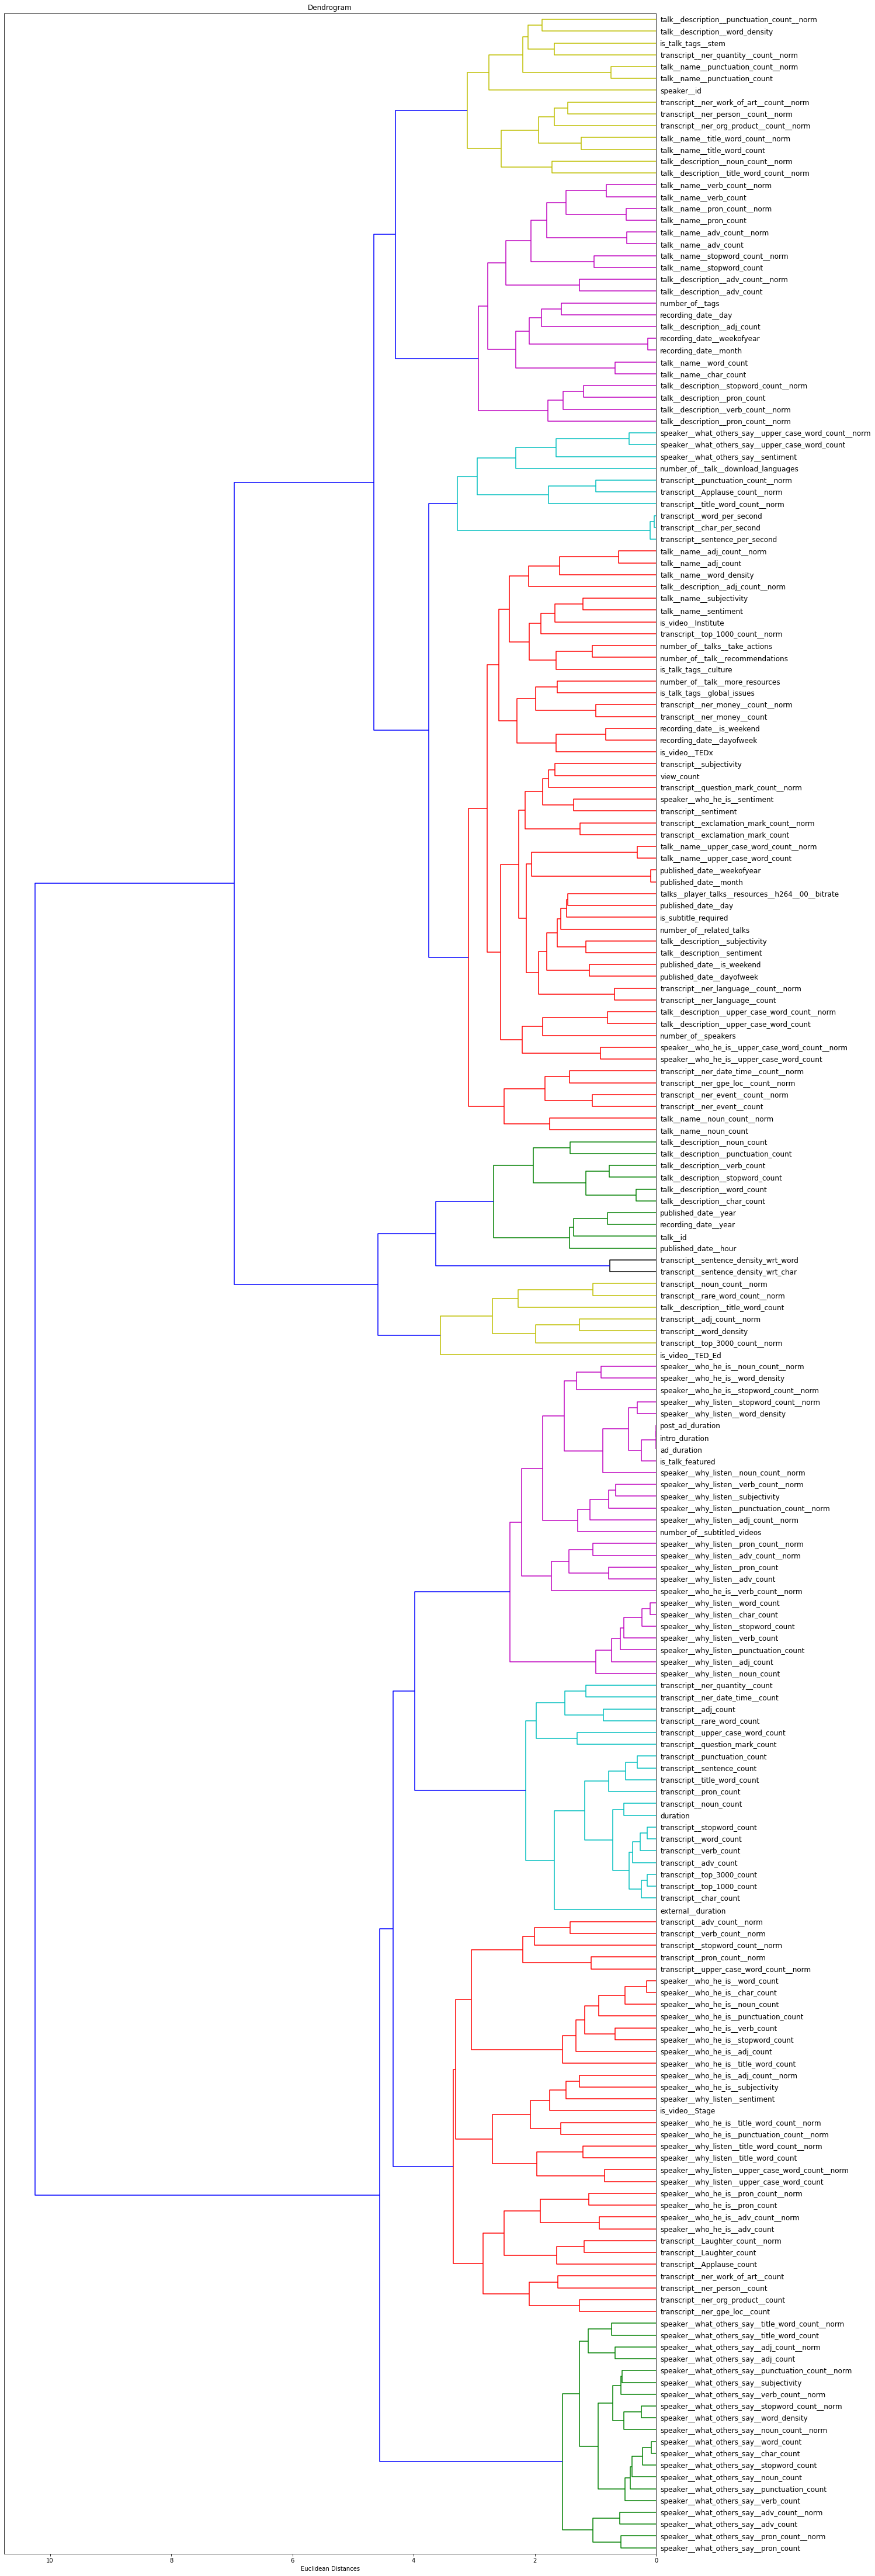

In [275]:
import scipy.cluster.hierarchy as sch

d = sch.distance.pdist(df_corr.values)
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.35*d.max(), 'distance')
columns  =  [df_corr.columns.tolist()[i]  for i in list(np.argsort(ind))]

dendrogram  =  sch.dendrogram(L,
                              color_threshold=0.35*d.max(),
                              labels=df_corr.columns.tolist(), 
                              orientation='left',
                              leaf_font_size=12)

plt.rcParams["figure.figsize"] = (20,80)
plt.title('Dendrogram')
plt.xlabel('Euclidean Distances')
plt.show()

In [276]:
# df.to_pickle('df.pkl')
df = pd.read_pickle('df.pkl')

In [279]:
df.shape

(4312, 267)

# Most common words/phrases

### Tokens/Words

In [280]:
# Source:  https://github.com/susanli2016/NLP-with-Python/blob/master/EDA%20and%20visualization%20for%20Text%20Data.ipynb
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n(corpus, nr, n=20):
    vec = CountVectorizer(ngram_range=(nr,nr), stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


In [286]:
# On entire 'transcript__2' column.
common_words = get_top_n(df['transcript__2'], 1)
for word, freq in common_words:    print(word, freq)

people 28806
like 28566
just 23572
know 18608
going 17371
think 17103
time 15915
really 15312
laughter 14424
world 14112
way 13254
did 12975
years 12623
actually 12035
make 11915
things 11849
want 11589
right 11190
new 9888
work 9539


In [284]:
# On first 'transcript2'.
common_words = get_top_n(df[['transcript__2']].iloc[0], 1)
for word, freq in common_words:    print(word, freq)

laughter 40
think 26
education 22
said 22
did 17
people 16
say 10
things 10
way 10
want 9
know 9
like 9
school 9
just 8
children 8
really 8
human 7
actually 7
world 7
kids 7


In [287]:
# On first 'transcript__5'.
common_words = get_top_n(df[['transcript__5']].iloc[0], 1)
for word, freq in common_words:    print(word, freq)

laughter 40
educate 6
capacity 6
earth 6
dance 6
intelligence 6
creativity 5
wonderful 5
ballet 5
extraordinary 4
applause 4
bear 4
creative 4
university 4
academic 4
royal 4
frankly 3
god 3
talent 3
gift 3


### Bigrams

In [289]:
# On entire 'transcript__2' column.
common_words = get_top_n(df['transcript__2'], 2)
for word, freq in common_words:    print(word, freq)

thank applause 3133
years ago 2678
little bit 2099
united states 1743
new york 1253
things like 1088
look like 1060
just like 1034
looks like 973
did know 941
years old 918
year old 915
laughter applause 847
climate change 847
10 years 695
make sure 681
people like 674
long time 661
20 years 612
health care 605


In [290]:
# On entire 'transcript__5' column.
common_words = get_top_n(df['transcript__5'], 2)
for word, freq in common_words:    print(word, freq)

laughter applause 1033
laughter laughter 805
applause applause 610
percent percent 503
brain brain 414
carbon dioxide 263
global warming 244
fossil fuel 234
datum datum 225
artificial intelligence 211
dollar dollar 197
york times 187
lady gentleman 175
trillion dollar 174
applause cheer 166
robot robot 161
planet earth 159
male female 158
coral reef 155
silicon valley 149


In [291]:
# On first 'transcript2'.
common_words = get_top_n(df[['transcript__2']].iloc[0], 2)
for word, freq in common_words:    print(word, freq)

did want 4
royal ballet 4
want talk 3
work education 3
frankly laughter 3
boy said 3
los angeles 3
public education 3
education actually 2
say work 2
education think 2
thank applause 2
drawing lesson 2
teacher said 2
said girl 2
said drawing 2
girl said 2
said bring 2
frightened wrong 2
prepared wrong 2


### Trigrams

In [293]:
# On entire 'transcript__2' column.
common_words = get_top_n(df['transcript__2'], 3)
for word, freq in common_words:    print(word, freq)

new york city 322
applause thank applause 233
thank applause thank 201
new york times 187
000 years ago 172
world war ii 156
10 years ago 145
little bit like 130
million years ago 127
just little bit 119
couple years ago 117
20 years ago 109
thank thank applause 106
sub saharan africa 100
applause chris anderson 97
talk little bit 96
spend lot time 88
tell little bit 83
does look like 82
10 000 years 80


# Key Phrase Extraction

In [315]:
text = df.transcript__2.iloc[0]
count = 20

In [316]:
!python -m spacy download en_core_web_sm
!pip install pytextrank
!pip install -r pytextrank/requirements.txt

!pip install rake-nltk

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [317]:
# From Pytextrank
import spacy
import pytextrank

nlp = spacy.load("en_core_web_sm")

# add PyTextRank to the spaCy pipeline
tr = pytextrank.TextRank()
nlp.add_pipe(tr.PipelineComponent, name="textrank", last=True)

doc = nlp(text)
for p in doc._.phrases[:count]:
    print("{:.4f} {:5d}".format(p.rank, p.count), '\t', p.text, '\t', p.chunks)

0.0618     1 	 national education systems 	 [national education systems]
0.0584     3 	 public education 	 [public education, public education, public education]
0.0578    14 	 education 	 [education, education, education, education, education, education, education, education, education, education, education, education, education, their education]
0.0502     1 	 other things 	 [other things]
0.0489     1 	 most people 	 [most people]
0.0482    11 	 people 	 [people, people, people, people, people, people, people, people, people, the people, the people]
0.0473    10 	 things 	 [things, things, things, those things, these things, the thing, three things, some things, all the things, all these things]
0.0459     1 	 human capacity 	 [human capacity]
0.0457     1 	 more people 	 [More people]
0.0439     1 	 human creativity 	 [human creativity]
0.0422     1 	 human ecology 	 [human ecology]
0.0413     1 	 gillian lynne 	 [Gillian Lynne]
0.0405     1 	 different disciplinary ways 	 [differe

In [318]:
# From Rake algorithm
from rake_nltk import Rake
r = Rake() 

r.extract_keywords_from_text(text)
keywords_  =  r.get_ranked_phrases_with_scores() 
for  i  in keywords_[:count]:    print((i[1], i[0]))


('never find another girl like sarah ."', 25.320261437908496)
('girl hardly ever paid attention', 24.0)
('successful musical theater productions', 16.0)
('met andrew lloyd webber', 16.0)
('must try harder ."', 14.764705882352942)
('probably steered benignly away', 13.5)
('teaches dance every day', 13.35)
('running national education systems', 13.055555555555555)
('god looks like ."', 11.986928104575163)
('life would flourish ."', 11.473039215686274)
('pretty much every system', 11.15)
('gillian lynne dance company', 11.133333333333333)
('great story recently —', 10.166666666666668)
('three themes running', 9.5)
('somebodys english class', 9.0)
('playing video games', 9.0)
('many highly talented', 9.0)
('five years ago', 9.0)
('al gore spoke', 9.0)
('stop speaking like', 8.88888888888889)


In [319]:
# From Gensim
from gensim.summarization import keywords
keywords_  =  keywords(text, words=count, scores = True, lemmatize = True)
for i in keywords_:    print(i)

('laughter', 0.5433658815516097)
('liked', 0.15846528994305886)
('people', 0.13360885327216984)
('humanities', 0.13010272297310732)
('said', 0.10975368128520507)
('called', 0.10744302672319532)
('universities', 0.10402322998542893)
('educate', 0.1028536408924354)
('story', 0.09781397833010785)
('boys', 0.09608866702804954)
('think', 0.09287791662948397)
('actually', 0.09268466153303254)
('years', 0.08878267411793946)
('creative', 0.08779255248444212)
('dance', 0.08724389349007834)
('new', 0.08413318894477183)
('academic', 0.0841331889447715)
('things', 0.08235792674377976)
('speaks', 0.0820615754286847)
('gift', 0.07838479795840765)


In [ ]:
# Clearly, Keyphrases from Pytextrank looks the best.

# A Simple Recommendation Engine with TFIDF and Cosine Similarity

In [346]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word', 
                     ngram_range=(1, 3), 
                     min_df=0, 
                     stop_words='english',
                     max_features=30000)

tfidf_matrix = tf.fit_transform(df['transcript__2'].fillna('') + \
                                df['talk__name'].fillna('') + \
                                df['speaker__name'].fillna('') + \
                                df['talk__description'].fillna('') + \
                                df['event'].fillna('') + \
                                df['speaker__why_listen'].fillna('') 
                                )

cosine_similarities = cosine_similarity(tfidf_matrix)

In [347]:
%%time
top_k = 15    # Count of predictions we are making.

indices = []    # Of most related talks.
for  j  in range(len(df)):
    c = cosine_similarities[j]
    c2 = sorted(zip(c, range(len(c))), key = lambda x:-x[0])[1:top_k+1]
    idx = [i[1]  for i in c2]
    indices.append(idx)


l = []
for  i  in range(len(df)):
    l.append([df.iloc[i]['talk__name'], 
              [df.iloc[j]['talk__name']  for  j  in indices[i]],
              [j['title']  for j in ast.literal_eval(df.iloc[i]['related_talks'])]])
    
final  =  pd.DataFrame(l, columns = ['talk__name', 'recommened_by_RE', 'related_talks'])    # RE for Recommendation Engine


# Creating  'match_ratio'  column.
def jaccard(l1, l2):
    if l2:
        s1, s2  =  set(l1), set(l2)
        return len(s1.intersection(s2))/len(s2)
    else:    return -1
final['match_ratio']  =  final.apply(lambda x:jaccard(x['recommened_by_RE'], x['related_talks']), axis=1)

CPU times: user 51 s, sys: 845 ms, total: 51.8 s
Wall time: 50.6 s


In [348]:
final.head()

,talk__name,recommened_by_RE,related_talks,match_ratio
0,Do schools kill creativity?,"[Bring on the learning revolution!, How to escape education's death valley, Sir Ken Robinson (still) wants an education revolution\t, Nerdcore comedy, A one-man world summit, How to run a company with (almost) no rules, Every kid needs a champion, Design and discovery, Our failing schools. Enoug...","[Sir Ken Robinson (still) wants an education revolution\t, Bring on the learning revolution!, How to escape education's death valley, How to run a company with (almost) no rules, The search for ""aha!"" moments, Why some of us don't have one true calling]",0.666667
1,This is what happens when you reply to spam email,"[The agony of trying to unsubscribe, Nerdcore comedy, A one-man world summit, Letting go of God, All things are Moleeds, Love, no matter what, Every kid needs a champion, Depression, the secret we share, Bring on the learning revolution!, A comic sendup of TED2006, Strange answers to the psychop...","[Why we laugh, If I controlled the Internet, The agony of trying to unsubscribe, How to stop screwing yourself over]",0.250000
2,Your body language may shape who you are,"[How to understand power, How to stop screwing yourself over, How to speak up for yourself, It's OK to feel overwhelmed. Here's what to do next, Play! Experiment! Discover!, What does the future hold? 11 characters offer quirky answers, How to run a company with (almost) no rules, How you can us...","[The power of vulnerability, How to let go of being a ""good"" person -- and become a better person, The gift and power of emotional courage, How to find work you love, It's OK to feel overwhelmed. Here's what to do next, How to speak up for yourself]",0.500000
3,How great leaders inspire action,"[Why good leaders make you feel safe, How to get your ideas to spread, How to find work you love, Why we make bad decisions, Fifty shades of gay, The path to ending systemic racism in the US, How brain science will change computing, How to build a company where the best ideas win, The tribes we ...","[Why good leaders make you feel safe, 3 questions to ask yourself about everything you do, Why the secret to success is setting the right goals, How to pitch to a VC, Confessions of a recovering micromanager, How we need to remake the internet]",0.166667
4,The power of vulnerability,"[Listening to shame, It's OK to feel overwhelmed. Here's what to do next, How changing your story can change your life, Why children stay silent following sexual violence, Play! Experiment! Discover!, How to run a company with (almost) no rules, A one-woman global village, Connected, but alone?,...","[Listening to shame, Gaming to re-engage boys in learning, Our loss of wisdom, It's OK to feel overwhelmed. Here's what to do next, The lies our culture tells us about what matters -- and a better way to live, How to turn climate anxiety into action]",0.333333


In [349]:
(final.match_ratio==-1).sum(), final.match_ratio.mean()

(0, 0.48644094001236887)

In [350]:
# Conclusion:  Only with this simple code, we could correctly recommend almost half of the 'related_talks' on average.

# Topic Modelling of 'transcript__5'

In [374]:
# Source:  https://github.com/susanli2016/NLP-with-Python/blob/master/Topic%20Modeling%20for%20Data%20Preprocessing.ipynb
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                         # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=30000,                # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(df['transcript__5'])

In [377]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=8,           # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1                
                                     )

lda_output = lda_model.fit_transform(data_vectorized)

In [378]:
# Show top k keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,brain,sleep,laughter,percent,mental,stress,emotion,gene,normal,medicine,self,healthy,disorder,surgery,depression,emotional,tumor,symptom,illness,therapy
Topic 1,percent,dollar,datum,global,income,access,united,china,innovation,applause,poverty,solution,invest,solve,crisis,trust,average,sector,tool,wealth
Topic 2,climate,percent,carbon,global,virus,planet,vaccine,fuel,forest,earth,waste,farmer,clean,solution,nuclear,solar,plastic,emission,scale,farm
Topic 3,earth,datum,planet,universe,object,sun,map,galaxy,particle,wave,speed,moon,physics,hole,intelligence,quantum,laughter,algorithm,sky,scale
Topic 4,applause,god,conversation,laughter,united,justice,bear,gender,prison,identity,medium,religion,freedom,conflict,compassion,refugee,self,struggle,democracy,hate
Topic 5,ocean,specie,male,bird,female,shark,coral,creature,whale,ant,dinosaur,egg,reef,elephant,marine,boat,swim,ship,ancestor,wild
Topic 6,laughter,applause,video,amazing,york,ted,connect,basically,fun,completely,wonderful,creative,dance,photo,paint,favorite,perfect,architecture,train,interested
Topic 7,robot,brain,device,molecule,protein,lab,neuron,tissue,bacteria,applause,shape,signal,chemical,smell,muscle,laughter,bee,sugar,biology,organ


In [379]:
# TODO:  Currently, the topics are not clear, and terms/topics are overlapping. Do more preprocessing, and find the optimal number of topics. Then, use Topic Model features for Clustering.